In [1]:
import pandas as pd

In [2]:
# Dataset da variavel target
df_aprovados = pd.read_csv('https://raw.githubusercontent.com/FIAP/Pos_Tech_DTAT/dd201a034223a16732c6f639b40600b26bd3129c/dados/clientes_aprovados.csv')

# Dataset tratado no primeiro script
df_cadastrados = pd.read_csv('../../dados/credit_score/clientes_cadastrados_clean.csv')

In [3]:
# ID Cliente -> Join com df_cadastrados
# Mes_referencia -> 0 = mês atual, -1 = mês passado, etc.
# Faixa_atraso -> quanto tempo atrasou o pagamento
df_aprovados.head()

,ID_Cliente,Mes_referencia,Faixa_atraso
0,5001711,0,nenhum empréstimo
1,5001711,-1,1-29 dias
2,5001711,-2,1-29 dias
3,5001711,-3,1-29 dias
4,5001712,0,pagamento realizado


In [4]:
# Valores possíveis para Faixa_atraso
df_aprovados['Faixa_atraso'].value_counts()

Faixa_atraso
pagamento realizado    442031
1-29 dias              383120
nenhum empréstimo      209230
30-59 dias              11090
>150 dias                1693
60-89 dias                868
90-119 dias               320
120-149 dias              223
Name: count, dtype: int64

In [5]:
# Exemplo de linhas para um cliente específico
df_aprovados.loc[df_aprovados['ID_Cliente'] == 5001712]

,ID_Cliente,Mes_referencia,Faixa_atraso
4,5001712,0,pagamento realizado
5,5001712,-1,pagamento realizado
6,5001712,-2,pagamento realizado
7,5001712,-3,pagamento realizado
8,5001712,-4,pagamento realizado
9,5001712,-5,pagamento realizado
10,5001712,-6,pagamento realizado
11,5001712,-7,pagamento realizado
12,5001712,-8,pagamento realizado
13,5001712,-9,1-29 dias


**Variável target**: cliente é bom ou mau pagador?

Isso requere etapa de feature engineering, ponderar diversos fatores!

# Feature Engineering

## Mês de abertura e fechamento das contas

In [6]:
df_goupby_id = df_aprovados.groupby('ID_Cliente').agg(Mes_inicio_conta=('Mes_referencia','min'), Mes_fim_conta = ('Mes_referencia','max')).reset_index()
df_goupby_id

,ID_Cliente,Mes_inicio_conta,Mes_fim_conta
0,5001711,-3,0
1,5001712,-18,0
2,5001713,-21,0
3,5001714,-14,0
4,5001715,-59,0
...,...,...,...
45980,5150482,-28,-11
45981,5150483,-17,0
45982,5150484,-12,0
45983,5150485,-1,0


In [7]:
# Merge no df aprovados
df_aprovados_mes = df_aprovados.merge(df_goupby_id, on='ID_Cliente')
df_aprovados_mes

,ID_Cliente,Mes_referencia,Faixa_atraso,Mes_inicio_conta,Mes_fim_conta
0,5001711,0,nenhum empréstimo,-3,0
1,5001711,-1,1-29 dias,-3,0
2,5001711,-2,1-29 dias,-3,0
3,5001711,-3,1-29 dias,-3,0
4,5001712,0,pagamento realizado,-18,0
...,...,...,...,...,...
1048570,5150487,-25,pagamento realizado,-29,0
1048571,5150487,-26,pagamento realizado,-29,0
1048572,5150487,-27,pagamento realizado,-29,0
1048573,5150487,-28,pagamento realizado,-29,0


## Número de meses

In [8]:
df_aprovados_mes['N_meses'] = df_aprovados_mes['Mes_fim_conta'] - df_aprovados_mes['Mes_inicio_conta']

In [9]:
df_aprovados_mes

,ID_Cliente,Mes_referencia,Faixa_atraso,Mes_inicio_conta,Mes_fim_conta,N_meses
0,5001711,0,nenhum empréstimo,-3,0,3
1,5001711,-1,1-29 dias,-3,0,3
2,5001711,-2,1-29 dias,-3,0,3
3,5001711,-3,1-29 dias,-3,0,3
4,5001712,0,pagamento realizado,-18,0,18
...,...,...,...,...,...,...
1048570,5150487,-25,pagamento realizado,-29,0,29
1048571,5150487,-26,pagamento realizado,-29,0,29
1048572,5150487,-27,pagamento realizado,-29,0,29
1048573,5150487,-28,pagamento realizado,-29,0,29


## MOB

Months on Book -> para cada mês de referência, indica há quantos meses o relacionamento com o cliente se iniciou

MOB = Mes_referencia - Mes_inicio_conta

In [10]:
df_aprovados_mob = df_aprovados_mes.copy()

In [11]:
df_aprovados_mob['MOB'] = df_aprovados_mob['Mes_referencia'] - df_aprovados_mob['Mes_inicio_conta']

In [12]:
df_aprovados_mob

,ID_Cliente,Mes_referencia,Faixa_atraso,Mes_inicio_conta,Mes_fim_conta,N_meses,MOB
0,5001711,0,nenhum empréstimo,-3,0,3,3
1,5001711,-1,1-29 dias,-3,0,3,2
2,5001711,-2,1-29 dias,-3,0,3,1
3,5001711,-3,1-29 dias,-3,0,3,0
4,5001712,0,pagamento realizado,-18,0,18,18
...,...,...,...,...,...,...,...
1048570,5150487,-25,pagamento realizado,-29,0,29,4
1048571,5150487,-26,pagamento realizado,-29,0,29,3
1048572,5150487,-27,pagamento realizado,-29,0,29,2
1048573,5150487,-28,pagamento realizado,-29,0,29,1


## Cliente ativo

In [13]:
df_aprovados_mob['Cliente_ativo'] = df_aprovados_mob['Mes_fim_conta'].apply(lambda x: 1 if x == 0 else 0)

In [14]:
df_aprovados_mob

,ID_Cliente,Mes_referencia,Faixa_atraso,Mes_inicio_conta,Mes_fim_conta,N_meses,MOB,Cliente_ativo
0,5001711,0,nenhum empréstimo,-3,0,3,3,1
1,5001711,-1,1-29 dias,-3,0,3,2,1
2,5001711,-2,1-29 dias,-3,0,3,1,1
3,5001711,-3,1-29 dias,-3,0,3,0,1
4,5001712,0,pagamento realizado,-18,0,18,18,1
...,...,...,...,...,...,...,...,...
1048570,5150487,-25,pagamento realizado,-29,0,29,4,1
1048571,5150487,-26,pagamento realizado,-29,0,29,3,1
1048572,5150487,-27,pagamento realizado,-29,0,29,2,1
1048573,5150487,-28,pagamento realizado,-29,0,29,1,1


## Faixa_atraso

Mudar Faixa_atraso para valores numéricos

In [15]:
df_aprovados_faixa_atraso = df_aprovados_mob.copy()

In [16]:
df_aprovados_faixa_atraso['Faixa_atraso'].unique()

array(['nenhum empréstimo', '1-29 dias', 'pagamento realizado',
       '30-59 dias', '60-89 dias', '90-119 dias', '120-149 dias',
       '>150 dias'], dtype=object)

In [17]:
dict_faixa_atraso = {'nenhum empréstimo':0, 'pagamento realizado':1,'1-29 dias':2,
       '30-59 dias':3, '60-89 dias':4, '90-119 dias':5, '120-149 dias':6,
       '>150 dias':7}

In [18]:
df_aprovados_faixa_atraso['Int_Faixa_atraso'] = df_aprovados_faixa_atraso['Faixa_atraso'].map(dict_faixa_atraso)
df_aprovados_faixa_atraso.drop(columns=['Faixa_atraso'], inplace=True)
df_aprovados_faixa_atraso.rename(columns={'Int_Faixa_atraso':'Faixa_atraso'}, inplace=True)

## Variável Bom/Mau pagador

In [19]:
df_aprovados_pagadores = df_aprovados_faixa_atraso.copy()

In [20]:
df_aprovados_pagadores['Mau_pagador'] = df_aprovados_pagadores['Faixa_atraso'].apply(lambda x: 1 if x > 2 else 0)

In [21]:
df_aprovados_pagadores

,ID_Cliente,Mes_referencia,Mes_inicio_conta,Mes_fim_conta,N_meses,MOB,Cliente_ativo,Faixa_atraso,Mau_pagador
0,5001711,0,-3,0,3,3,1,0,0
1,5001711,-1,-3,0,3,2,1,2,0
2,5001711,-2,-3,0,3,1,1,2,0
3,5001711,-3,-3,0,3,0,1,2,0
4,5001712,0,-18,0,18,18,1,1,0
...,...,...,...,...,...,...,...,...,...
1048570,5150487,-25,-29,0,29,4,1,1,0
1048571,5150487,-26,-29,0,29,3,1,1,0
1048572,5150487,-27,-29,0,29,2,1,1,0
1048573,5150487,-28,-29,0,29,1,1,1,0


## Número de vezes que foi mau pagador

In [22]:
df_groupby_n_mau_pagador = df_aprovados_pagadores.groupby('ID_Cliente').agg(N_Mau_pagador = ('Mau_pagador','sum')).reset_index()
df_groupby_n_mau_pagador

,ID_Cliente,N_Mau_pagador
0,5001711,0
1,5001712,0
2,5001713,0
3,5001714,0
4,5001715,0
...,...,...
45980,5150482,0
45981,5150483,0
45982,5150484,0
45983,5150485,0


In [23]:
df_aprovados_pagadores = df_aprovados_pagadores.merge(df_groupby_n_mau_pagador, on='ID_Cliente')

In [24]:
df_aprovados_pagadores

,ID_Cliente,Mes_referencia,Mes_inicio_conta,Mes_fim_conta,N_meses,MOB,Cliente_ativo,Faixa_atraso,Mau_pagador,N_Mau_pagador
0,5001711,0,-3,0,3,3,1,0,0,0
1,5001711,-1,-3,0,3,2,1,2,0,0
2,5001711,-2,-3,0,3,1,1,2,0,0
3,5001711,-3,-3,0,3,0,1,2,0,0
4,5001712,0,-18,0,18,18,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1048570,5150487,-25,-29,0,29,4,1,1,0,0
1048571,5150487,-26,-29,0,29,3,1,1,0,0
1048572,5150487,-27,-29,0,29,2,1,1,0,0
1048573,5150487,-28,-29,0,29,1,1,1,0,0


## Proporção de meses como mau pagador

In [25]:
df_aprovados_pagadores['Ratio_Mau_pagador'] = df_aprovados_pagadores.apply(lambda x: (x['N_Mau_pagador'] / x['N_meses']) * 100 if x['N_meses'] > 0 else 0, axis=1)

In [26]:
df_aprovados_pagadores['Ratio_Mau_pagador'].value_counts()

Ratio_Mau_pagador
0.000000     904765
5.263158       2682
5.000000       2647
7.142857       2596
5.882353       2530
              ...  
92.857143        15
53.846154        14
84.615385        14
72.727273        12
87.500000         9
Name: count, Length: 395, dtype: int64

## Análise Vintage

### Qtd de clientes por Mes Inicio Conta

In [27]:
# Criação de DF com ID_Clientes unicos, considerando apenas o mês mais atual de registro
df_clientes_drop_duplicates = df_aprovados_pagadores.drop_duplicates(subset='ID_Cliente', keep='first')
df_clientes_drop_duplicates.reset_index(drop=True, inplace=True)
df_clientes_drop_duplicates

,ID_Cliente,Mes_referencia,Mes_inicio_conta,Mes_fim_conta,N_meses,MOB,Cliente_ativo,Faixa_atraso,Mau_pagador,N_Mau_pagador,Ratio_Mau_pagador
0,5001711,0,-3,0,3,3,1,0,0,0,0.0
1,5001712,0,-18,0,18,18,1,1,0,0,0.0
2,5001713,0,-21,0,21,21,1,0,0,0,0.0
3,5001714,0,-14,0,14,14,1,0,0,0,0.0
4,5001715,0,-59,0,59,59,1,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
45980,5150482,-11,-28,-11,17,17,0,1,0,0,0.0
45981,5150483,0,-17,0,17,17,1,0,0,0,0.0
45982,5150484,0,-12,0,12,12,1,1,0,0,0.0
45983,5150485,0,-1,0,1,1,1,2,0,0,0.0


In [28]:
# Contagem de clientes únicos em cada valor de 
df_abertura = df_clientes_drop_duplicates.groupby('Mes_inicio_conta').agg({'ID_Cliente':'count'}).reset_index()
df_abertura.rename(columns={'ID_Cliente':'Qtd_Clientes'}, inplace=True)
df_abertura

,Mes_inicio_conta,Qtd_Clientes
0,-60,415
1,-59,406
2,-58,440
3,-57,400
4,-56,470
...,...,...
56,-4,874
57,-3,919
58,-2,771
59,-1,686


In [29]:
# Criação de DF Vintage: Agrupamento por Mes Inicio Conta e MOB (Months on Book)
df_vintage = df_aprovados_pagadores.groupby(['Mes_inicio_conta','MOB']).agg({'ID_Cliente':'count'}).reset_index()
df_vintage.rename(columns={'ID_Cliente':'Qtd_Clientes'}, inplace=True)
df_vintage

,Mes_inicio_conta,MOB,Qtd_Clientes
0,-60,0,415
1,-60,1,414
2,-60,2,410
3,-60,3,408
4,-60,4,403
...,...,...,...
1886,-2,1,770
1887,-2,2,750
1888,-1,0,686
1889,-1,1,682


In [30]:
## Isso não parece correto, vou desconsiderar!


# Merge df vintage e df abertura
df_vintage = df_vintage[['Mes_inicio_conta','MOB']].merge(df_abertura, on='Mes_inicio_conta', how='left')
df_vintage

,Mes_inicio_conta,MOB,Qtd_Clientes
0,-60,0,415
1,-60,1,415
2,-60,2,415
3,-60,3,415
4,-60,4,415
...,...,...,...
1886,-2,1,771
1887,-2,2,771
1888,-1,0,686
1889,-1,1,686


### Proporção maus pagadores

In [31]:
import numpy as np

df_vintage['Qtde_Mau_pagador'] = np.nan

In [32]:
df_aprovados_pagadores.loc[(df_aprovados_pagadores['Mes_inicio_conta'] == -60) & (df_aprovados_pagadores['MOB'] == 60)]

,ID_Cliente,Mes_referencia,Mes_inicio_conta,Mes_fim_conta,N_meses,MOB,Cliente_ativo,Faixa_atraso,Mau_pagador,N_Mau_pagador,Ratio_Mau_pagador
377,5001730,0,-60,0,60,60,1,1,0,0,0.000000
9696,5002160,0,-60,0,60,60,1,2,0,0,0.000000
9869,5002165,0,-60,0,60,60,1,2,0,0,0.000000
9976,5002171,0,-60,0,60,60,1,1,0,0,0.000000
12322,5002283,0,-60,0,60,60,1,1,0,2,3.333333
...,...,...,...,...,...,...,...,...,...,...,...
1000847,5143482,0,-60,0,60,60,1,1,0,0,0.000000
1004969,5145767,0,-60,0,60,60,1,2,0,0,0.000000
1013592,5146385,0,-60,0,60,60,1,1,0,0,0.000000
1018288,5148524,0,-60,0,60,60,1,1,0,0,0.000000


In [33]:
for j in sorted(df_vintage['Mes_inicio_conta'].unique()):
    ls = []

    for i in range(0, len(df_vintage['Mes_inicio_conta'].unique()) +1):
        due = list(df_aprovados_pagadores.query("Mau_pagador == 1 and MOB == @i and Mes_inicio_conta == @j")['ID_Cliente'])

        n_mau_pagadores = len(due)

        df_vintage.loc[(df_vintage['MOB'] == i) & (df_vintage['Mes_inicio_conta'] == j), 'Qtde_Mau_pagador'] = n_mau_pagadores


df_vintage['Taxa_Mau_pagador'] = df_vintage['Qtde_Mau_pagador'] / df_vintage['Qtd_Clientes'] * 100

### Tabela Pivot

In [34]:
df_vintage

,Mes_inicio_conta,MOB,Qtd_Clientes,Qtde_Mau_pagador,Taxa_Mau_pagador
0,-60,0,415,0.0,0.000000
1,-60,1,415,2.0,0.481928
2,-60,2,415,6.0,1.445783
3,-60,3,415,5.0,1.204819
4,-60,4,415,9.0,2.168675
...,...,...,...,...,...
1886,-2,1,771,14.0,1.815824
1887,-2,2,771,14.0,1.815824
1888,-1,0,686,2.0,0.291545
1889,-1,1,686,10.0,1.457726


In [35]:
df_vintage_pivot = df_vintage.pivot(index='Mes_inicio_conta', columns='MOB', values='Taxa_Mau_pagador')
df_vintage_pivot

MOB,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
Mes_inicio_conta,,,,,,,,,,,,,,,,,,,,,
-60,0.000000,0.481928,1.445783,1.204819,2.168675,2.168675,2.409639,3.132530,2.650602,2.409639,...,0.722892,0.481928,0.481928,0.722892,0.481928,0.722892,0.722892,0.722892,0.722892,1.204819
-59,0.246305,1.231527,1.724138,2.463054,2.709360,2.463054,2.463054,2.463054,1.970443,2.955665,...,0.492611,1.231527,1.231527,0.738916,1.231527,1.231527,0.738916,0.738916,0.492611,NaN
-58,0.000000,1.136364,1.136364,1.136364,1.136364,1.136364,2.727273,1.590909,1.136364,1.818182,...,0.454545,0.000000,0.000000,0.227273,0.227273,0.000000,0.227273,0.227273,NaN,NaN
-57,0.000000,1.500000,1.250000,2.250000,2.250000,1.750000,2.250000,1.500000,2.000000,4.500000,...,0.500000,0.750000,0.500000,0.500000,0.750000,0.500000,0.500000,NaN,NaN,NaN
-56,0.000000,1.914894,1.914894,2.765957,2.127660,2.127660,2.553191,2.553191,3.404255,3.191489,...,0.212766,0.000000,0.000000,0.000000,0.212766,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-4,0.000000,0.800915,2.288330,2.860412,2.288330,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-3,0.000000,1.632209,1.632209,1.414581,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2,0.000000,1.815824,1.815824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
import seaborn as sns

In [37]:
df_vintage_pivot

MOB,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
Mes_inicio_conta,,,,,,,,,,,,,,,,,,,,,
-60,0.000000,0.481928,1.445783,1.204819,2.168675,2.168675,2.409639,3.132530,2.650602,2.409639,...,0.722892,0.481928,0.481928,0.722892,0.481928,0.722892,0.722892,0.722892,0.722892,1.204819
-59,0.246305,1.231527,1.724138,2.463054,2.709360,2.463054,2.463054,2.463054,1.970443,2.955665,...,0.492611,1.231527,1.231527,0.738916,1.231527,1.231527,0.738916,0.738916,0.492611,NaN
-58,0.000000,1.136364,1.136364,1.136364,1.136364,1.136364,2.727273,1.590909,1.136364,1.818182,...,0.454545,0.000000,0.000000,0.227273,0.227273,0.000000,0.227273,0.227273,NaN,NaN
-57,0.000000,1.500000,1.250000,2.250000,2.250000,1.750000,2.250000,1.500000,2.000000,4.500000,...,0.500000,0.750000,0.500000,0.500000,0.750000,0.500000,0.500000,NaN,NaN,NaN
-56,0.000000,1.914894,1.914894,2.765957,2.127660,2.127660,2.553191,2.553191,3.404255,3.191489,...,0.212766,0.000000,0.000000,0.000000,0.212766,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-4,0.000000,0.800915,2.288330,2.860412,2.288330,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-3,0.000000,1.632209,1.632209,1.414581,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2,0.000000,1.815824,1.815824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df_vintage_pivot.T.iloc[:, :10]

Mes_inicio_conta,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51
MOB,,,,,,,,,,
0,0.000000,0.246305,0.000000,0.00,0.000000,0.205761,0.000000,0.202840,0.180832,0.171821
1,0.481928,1.231527,1.136364,1.50,1.914894,1.646091,1.068376,1.622718,1.446655,1.374570
2,1.445783,1.724138,1.136364,1.25,1.914894,2.057613,1.282051,2.636917,2.169982,3.780069
3,1.204819,2.463054,1.136364,2.25,2.765957,2.469136,1.709402,1.825558,1.627486,2.577320
4,2.168675,2.709360,1.136364,2.25,2.127660,3.497942,2.991453,2.636917,1.627486,2.405498
...,...,...,...,...,...,...,...,...,...,...
56,0.722892,1.231527,0.000000,0.50,0.000000,NaN,NaN,NaN,NaN,NaN
57,0.722892,0.738916,0.227273,0.50,NaN,NaN,NaN,NaN,NaN,NaN
58,0.722892,0.738916,0.227273,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='MOB'>

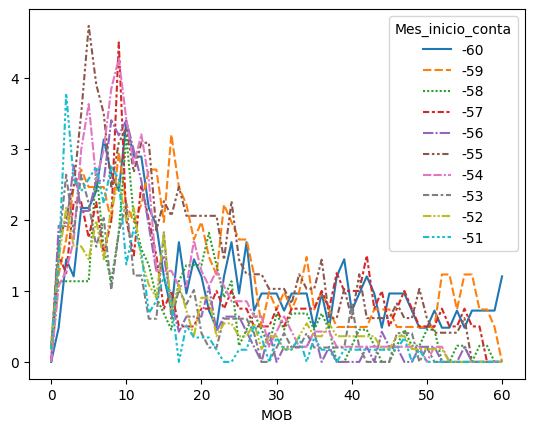

In [39]:
sns.lineplot(df_vintage_pivot.T.iloc[:, :10].fillna(0))

Percebe-se que existem mais clientes pagadores nos menores valores de MOB, ou seja, logo após abertura da conta há uma tendência dos clientes atrasarem o pagamento de dívidas.

Por outro lado, clientes com contas há mais tempo (maior MOB), geralmente são melhores pagadores.

<Axes: xlabel='N_meses', ylabel='Count'>

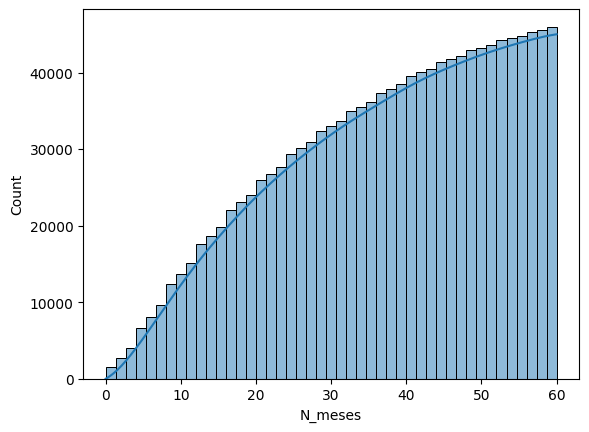

In [40]:
# Análise: acumulado de clientes por N_meses (janela)
sns.histplot(df_clientes_drop_duplicates, x='N_meses', cumulative=True, kde=True)

# Criação de variáveis binárias por faixa de atraso

In [41]:
dict_intervalo_atraso = {'60_dias':3,'90_dias':4,'120_dias':5,'150_dias':6, 'maior_150_dias':7}

In [42]:
for key,value in dict_intervalo_atraso.items():
    df_aprovados_pagadores[f'Mau_{key}'] = df_aprovados_pagadores.apply(lambda x: 1 if x['Faixa_atraso'] >= value else 0, axis=1)

In [43]:
df_aprovados_pagadores.query('Mau_90_dias == 1')

,ID_Cliente,Mes_referencia,Mes_inicio_conta,Mes_fim_conta,N_meses,MOB,Cliente_ativo,Faixa_atraso,Mau_pagador,N_Mau_pagador,Ratio_Mau_pagador,Mau_60_dias,Mau_90_dias,Mau_120_dias,Mau_150_dias,Mau_maior_150_dias
8911,5002126,-46,-55,0,55,9,1,4,1,6,10.909091,1,1,0,0,0
8912,5002126,-47,-55,0,55,8,1,5,1,6,10.909091,1,1,1,0,0
8913,5002126,-48,-55,0,55,7,1,5,1,6,10.909091,1,1,1,0,0
8914,5002126,-49,-55,0,55,6,1,4,1,6,10.909091,1,1,0,0,0
8915,5002126,-50,-55,0,55,5,1,4,1,6,10.909091,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041047,5149838,-23,-32,0,32,9,1,4,1,18,56.250000,1,1,0,0,0
1041048,5149838,-24,-32,0,32,8,1,4,1,18,56.250000,1,1,0,0,0
1044484,5150049,0,-9,0,9,9,1,4,1,2,22.222222,1,1,0,0,0
1046235,5150238,-5,-53,0,53,48,1,4,1,3,5.660377,1,1,0,0,0


## Análise: taxa de clientes mau pagadores por faixa de atraso

In [44]:
dict_taxa_mau = {}
id_sum = df_aprovados_pagadores['ID_Cliente'].nunique()

for key in dict_intervalo_atraso.keys():
    df_min_mau = df_aprovados_pagadores.query(f'Mau_{key} == 1').groupby('ID_Cliente').agg({'MOB':'min'}).reset_index()

    df_mob_taxa_mau = pd.DataFrame(columns=['MOB', 'Taxa_mau'])

    lst = []

    for i in range(0, df_aprovados_pagadores['MOB'].nunique()):
        due = df_min_mau.query('MOB == @i')['ID_Cliente'].to_list()
        lst.extend(due)

        df_mob_taxa_mau = pd.concat([df_mob_taxa_mau, pd.DataFrame(data={'MOB': [i], 'Taxa_mau': [len(set(lst))/id_sum]})])

    dict_taxa_mau[key] = df_mob_taxa_mau['Taxa_mau']

df_taxa_mau = pd.DataFrame(dict_taxa_mau)
df_taxa_mau.reset_index(drop=True, inplace=True)

In [45]:
display(df_taxa_mau.head())

,60_dias,90_dias,120_dias,150_dias,maior_150_dias
0,0.000304,0.000022,0.000022,0.000022,0.000022
1,0.011612,0.000174,0.000087,0.000087,0.000087
2,0.025878,0.001153,0.000196,0.000174,0.000174
3,0.036860,0.002240,0.000696,0.000304,0.000304
4,0.047385,0.003392,0.001044,0.000696,0.000348


In [46]:
import matplotlib.pyplot as plt

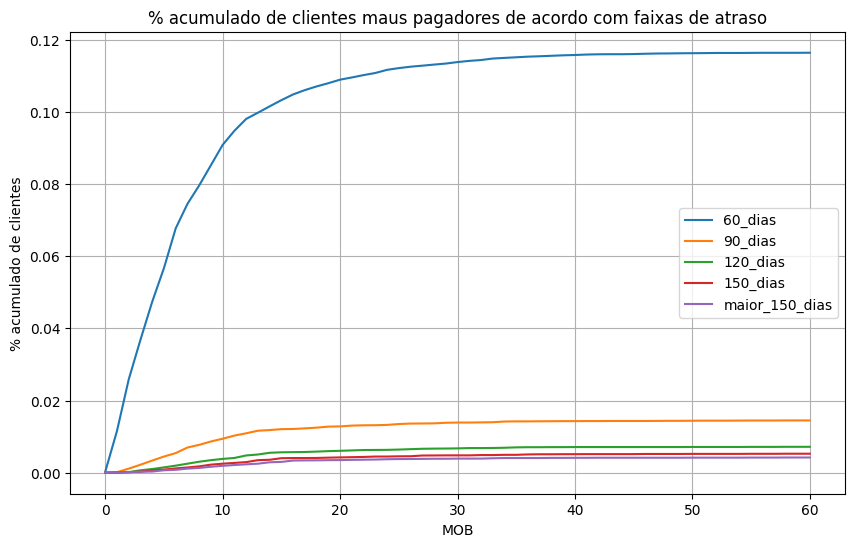

In [47]:
df_taxa_mau.plot(grid = True, title = '% acumulado de clientes maus pagadores de acordo com faixas de atraso', figsize=(10, 6))
plt.xlabel('MOB')
plt.ylabel('% acumulado de clientes')
plt.show()

Aparentemente a curva de atraso entre 30 e 60 dias é muito diferente das outras. Em geral, é muito mais comum que pessoas atrasem pagamentos por esse período de tempo.

Por isso, talvez seja uma boa ideia desconsiderar clientes que atrasaram nesta faixa entre 30 e 60 dias.

Outro ponto a se considerar é o número de meses que um cliente está cadastrado. Por exemplo, é possível dizer que uma pessoa é mau pagadora com base em um histórico de apenas 6 meses?

# Filtragem Dataframe

## Filtro de clientes com mais de 6 meses de histórico na base

In [48]:
df_aprovados_pagadores_filtered = df_aprovados_pagadores.query('N_meses > 6')
df_aprovados_pagadores_filtered.reset_index(drop=True, inplace=True)

In [49]:
df_aprovados_pagadores_filtered

,ID_Cliente,Mes_referencia,Mes_inicio_conta,Mes_fim_conta,N_meses,MOB,Cliente_ativo,Faixa_atraso,Mau_pagador,N_Mau_pagador,Ratio_Mau_pagador,Mau_60_dias,Mau_90_dias,Mau_120_dias,Mau_150_dias,Mau_maior_150_dias
0,5001712,0,-18,0,18,18,1,1,0,0,0.0,0,0,0,0,0
1,5001712,-1,-18,0,18,17,1,1,0,0,0.0,0,0,0,0,0
2,5001712,-2,-18,0,18,16,1,1,0,0,0.0,0,0,0,0,0
3,5001712,-3,-18,0,18,15,1,1,0,0,0.0,0,0,0,0,0
4,5001712,-4,-18,0,18,14,1,1,0,0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012182,5150487,-25,-29,0,29,4,1,1,0,0,0.0,0,0,0,0,0
1012183,5150487,-26,-29,0,29,3,1,1,0,0,0.0,0,0,0,0,0
1012184,5150487,-27,-29,0,29,2,1,1,0,0,0.0,0,0,0,0,0
1012185,5150487,-28,-29,0,29,1,1,1,0,0,0.0,0,0,0,0,0


# Criação da variável target final

In [57]:
def verifica(registros):
  lista_status = registros['Faixa_atraso'].to_list()
  if 4 in lista_status or 5 in lista_status or 6 in lista_status or 7 in lista_status:
    return 1
  else:
    return 0

In [60]:
df_clientes_variavel_target = pd.DataFrame(df_aprovados_pagadores_filtered.groupby('ID_Cliente').apply(verifica)).reset_index()
df_clientes_variavel_target.columns = ['ID_Cliente','Risco_de_credito']
df_clientes_variavel_target

,ID_Cliente,Risco_de_credito
0,5001712,0
1,5001713,0
2,5001714,0
3,5001715,0
4,5001717,0
...,...,...
37868,5150481,0
37869,5150482,0
37870,5150483,0
37871,5150484,0


# Merge com dados de cadastro

In [62]:
df_cadastrados_target = df_cadastrados.merge(df_clientes_variavel_target, on='ID_Cliente')
df_cadastrados_target

,ID_Cliente,Tem_carro,Tem_casa_propria,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Idade,Anos_empregado,Tamanho_familia,Rendimento_anual,Categoria_de_renda,Grau_escolaridade,Estado_civil,Moradia,Ocupacao,Risco_de_credito
0,5008806,1,1,0,0,0,59,3,2,112500.0,Empregado,Ensino médio,Casado,Casa/apartamento próprio,Segurança,0
1,5008810,0,1,0,1,1,52,8,1,270000.0,Associado comercial,Ensino médio,Solteiro,Casa/apartamento próprio,Associado comercial,0
2,5008811,0,1,0,1,1,52,8,1,270000.0,Associado comercial,Ensino médio,Solteiro,Casa/apartamento próprio,Associado comercial,0
3,5008812,0,1,0,0,0,62,0,1,283500.0,Pensionista,Ensino superior,Divorciado,Casa/apartamento próprio,Pensionista,0
4,5008813,0,1,0,0,0,62,0,1,283500.0,Pensionista,Ensino superior,Divorciado,Casa/apartamento próprio,Pensionista,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28405,5149828,1,1,0,0,0,47,7,2,315000.0,Empregado,Ensino médio,Casado,Casa/apartamento próprio,Gerência,1
28406,5149834,0,1,0,1,1,34,4,2,157500.0,Associado comercial,Ensino superior,Casado,Casa/apartamento próprio,Associado comercial,1
28407,5149838,0,1,0,1,1,34,4,2,157500.0,Pensionista,Ensino superior,Casado,Casa/apartamento próprio,Pensionista,1
28408,5150049,0,1,0,0,0,49,2,2,283500.0,Empregado,Ensino médio,Casado,Casa/apartamento próprio,Vendas,1


In [64]:
df_cadastrados_target['Risco_de_credito'].value_counts(normalize=True)

Risco_de_credito
0    0.979937
1    0.020063
Name: proportion, dtype: float64